Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt:	A boy and a girl sitting on the bench in moonlight and girl holding hands of boy and leans her head on boys shoulder
Seed:	2730377919406338895


""

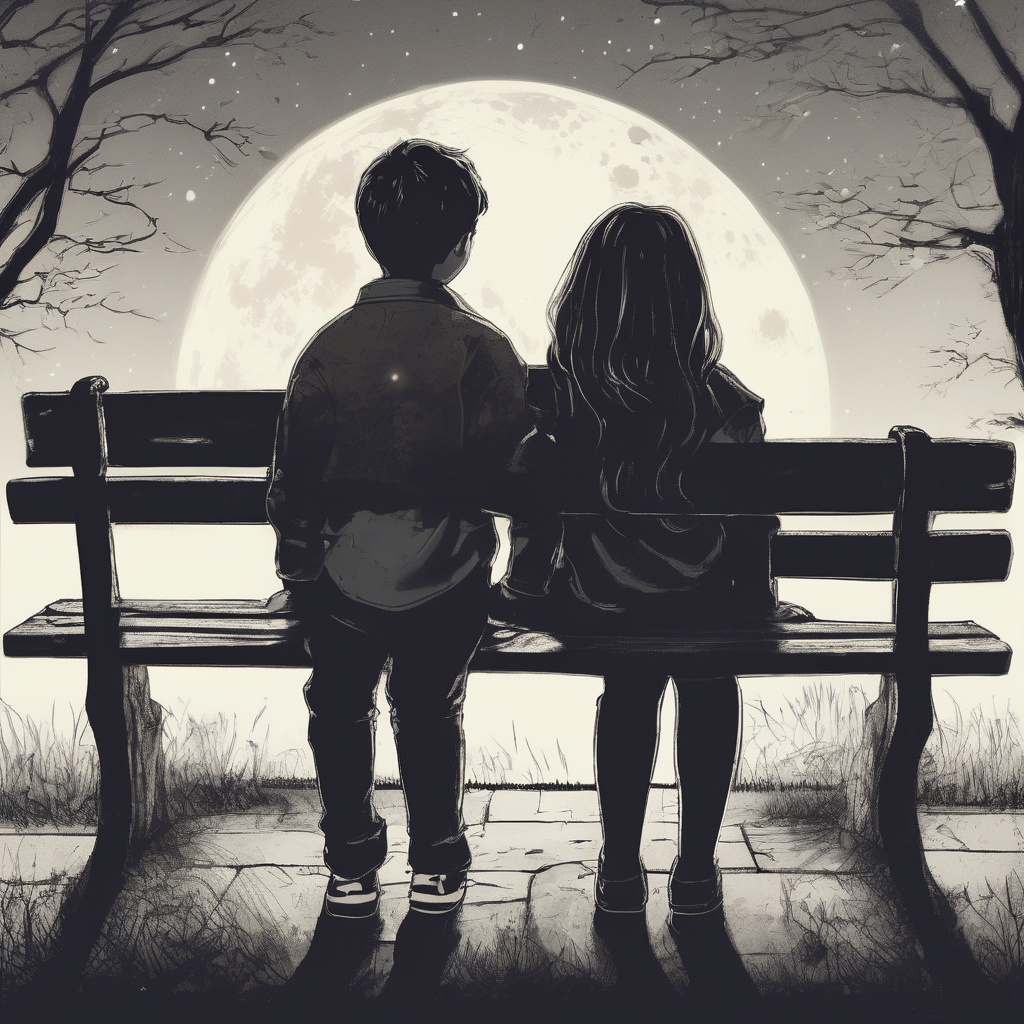

In [9]:
import mediapy as media
import random
import sys
import torch
from diffusers import DiffusionPipeline

# Define whether to use the refiner or not
use_refiner = False  # Set this to False if you don't want to use the refiner

# Load the base model
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)

# Load the refiner if use_refiner is True
if use_refiner:
    refiner = DiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-refiner-1.0",
        text_encoder_2=pipe.text_encoder_2,
        vae=pipe.vae,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
    )
    refiner = refiner.to("cuda")
    pipe.enable_model_cpu_offload()  # Offload the base model to CPU when using the refiner
else:
    pipe = pipe.to("cuda")

# Define your prompt
prompt = "A boy and a girl sitting on the bench in moonlight and girl holding hands of boy and leans her head on boys shoulder"

# Generate a random seed
seed = random.randint(0, sys.maxsize)

# Generate images
images = pipe(
    prompt=prompt,
    output_type="latent" if use_refiner else "pil",  # Use "latent" for refiner, else "pil"
    generator=torch.Generator("cuda").manual_seed(seed),
).images

# Refine the images if using the refiner
if use_refiner:
    images = refiner(
        prompt=prompt,
        image=images,
    ).images

# Display and save the generated image
print(f"Prompt:\t{prompt}\nSeed:\t{seed}")
media.show_images(images)
images[0].save("output.jpg")